In [65]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as st
import seaborn as sns
import xarray as xr
from numpy.linalg import inv
from scipy.stats import norm, uniform

In [2]:
import pymc_experimental as pmx

In [107]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

In [114]:
%matplotlib inline

In [3]:
d = pd.read_csv(
    "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv",
    sep=";",
)

1.2436303013880823

In [ ]:
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

In [ ]:
d.MedianAgeMarriage.std()

In [30]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,A,D,M
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,1.654205,0.022644
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.544364,1.549802
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00,-0.204241,0.610716,0.048974
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26,-1.410387,2.093569,1.655123
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00,0.599857,-0.927058,-0.266989


In [108]:
with pm.Model() as model_m5_1:
    Adata = pm.Data("A", d.A, dims="obs_id")
    a = pm.Normal("a", mu=0, sigma=0.2)
    bA = pm.Normal("bA", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * Adata, dims="obs_id")
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d.D, dims="obs_id")
    prior_m5_1 = pm.sample_prior_predictive(samples=50, random_seed=rng)

Sampling: [D, a, bA, sigma]


C:\Users\carsten.jorgensen\AppData\Local\Temp\ipykernel_32900\1046637360.py:13: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


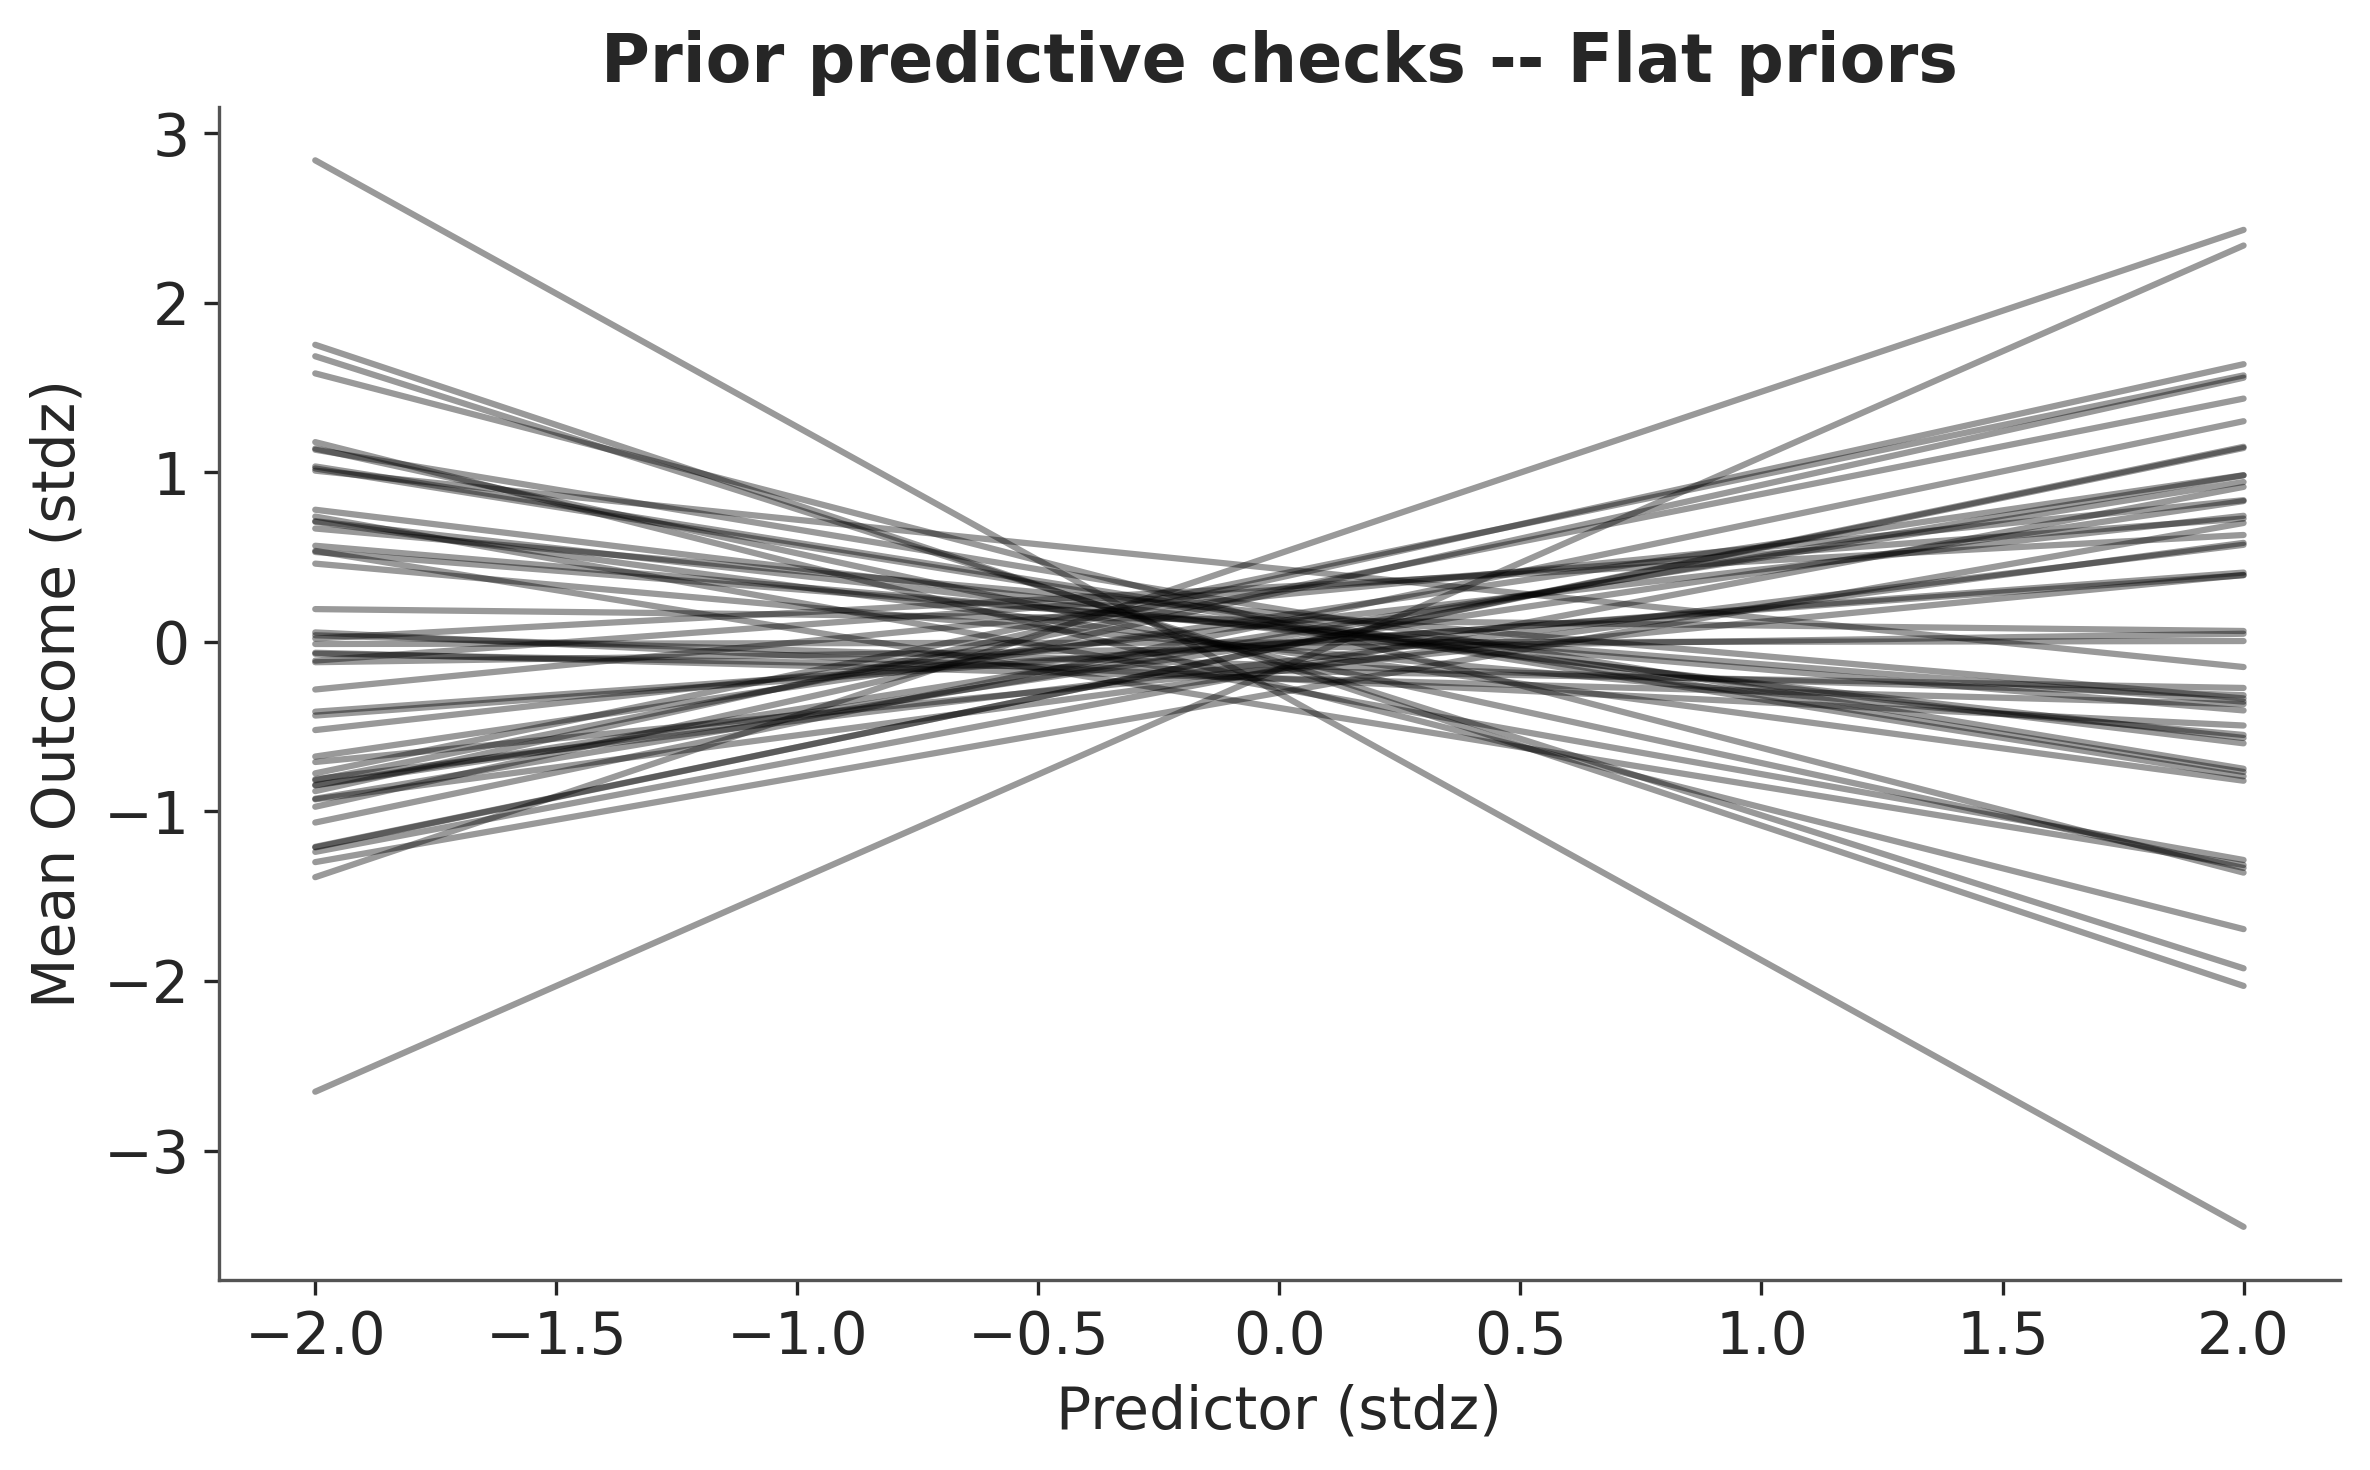

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

x = xr.DataArray(np.linspace(-2, 2, 50), dims=["plot_dim"])
prior = prior_m5_1.prior
y = prior["a"] + prior["bA"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors")

fig.tight_layout()
# plt.show();

In [85]:
idata_m5_1 = pmx.fit(
    method="laplace",
    vars=[a, bA, sigma],
    model=model_m5_1,
    draws=1000,
    chains=1,
    random_seed=173300,
    progressbar=False,
)

c:\Users\carsten.jorgensen\dev\Rethinking\.venv\Lib\site-packages\pymc\model\core.py:565: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
c:\Users\carsten.jorgensen\dev\Rethinking\.venv\Lib\site-packages\pytensor\configparser.py:47: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)


c:\Users\carsten.jorgensen\dev\Rethinking\.venv\Lib\site-packages\arviz\data\inference_data.py:1538: UserWarning: The group fit is not defined in the InferenceData scheme
  warnings.warn(


In [86]:
idata_m5_1

Inference data with groups:
	> posterior
	> observed_data
	> constant_data
	> fit

In [87]:
with pm.Model() as model_m5_2:
    Mdata = pm.ConstantData("M", d.M, dims="obs_id")
    a = pm.Normal("a", mu=0, sigma=0.2)
    bM = pm.Normal("bM", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * Mdata, dims="obs_id")
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d.D, dims="obs_id")
    vars = [a, bM, sigma]

idata_m5_2 = pmx.fit(
    method="laplace",
    vars=vars,
    model=model_m5_2,
    draws=1000,
    chains=1,
    random_seed=173300,
)

c:\Users\carsten.jorgensen\dev\Rethinking\.venv\Lib\site-packages\pymc\data.py:273: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

c:\Users\carsten.jorgensen\dev\Rethinking\.venv\Lib\site-packages\pymc\model\core.py:565: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
c:\Users\carsten.jorgensen\dev\Rethinking\.venv\Lib\site-packages\pytensor\configparser.py:47: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)


Output()

c:\Users\carsten.jorgensen\dev\Rethinking\.venv\Lib\site-packages\arviz\data\inference_data.py:1538: UserWarning: The group fit is not defined in the InferenceData scheme
  warnings.warn(


In [61]:
idata_m5_2

Inference data with groups:
	> posterior
	> observed_data
	> constant_data
	> fit

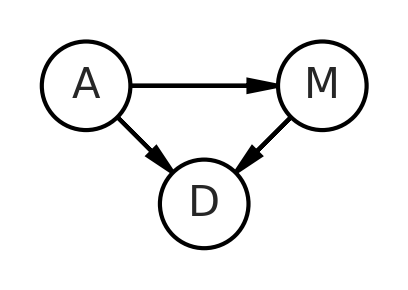

<Axes: >

In [106]:
# Instantiate the PGM.
pgm = daft.PGM(grid_unit=1.0, node_unit=0.75)

# Hierarchical parameters.
pgm.add_node("A", "A", 0, 0)
pgm.add_node("M", "M", 2, 0)
pgm.add_node("D", "D", 1, -1)

# Add in the edges.
pgm.add_edge("A", "M")
pgm.add_edge("A", "D")
pgm.add_edge("M", "D")

# Render and save.
pgm.render()

plt.show()

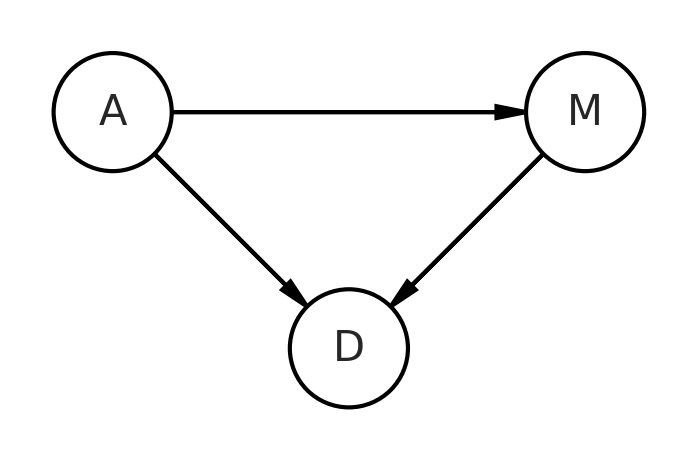

In [77]:
dag5_1 = nx.DiGraph()
dag5_1.add_edges_from([("A", "D"), ("A", "M"), ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.edges:
    pgm.add_edge(*edge)
with plt.rc_context({"figure.constrained_layout.use": False}):
    pgm.render()
plt.gca().invert_yaxis()
plt.show()

In [56]:
def precis(samples, var_names=None):
    return az.summary(samples, kind="stats", hdi_prob=0.89, var_names=var_names).round(
        2
    )

In [57]:
with pm.Model() as model_m5_3:
    Adata = pm.ConstantData("A", d.A, dims="obs_id")
    Mdata = pm.ConstantData("M", d.M, dims="obs_id")
    a = pm.Normal("a", mu=0, sigma=0.2)
    bA = pm.Normal("bA", mu=0, sigma=0.5)
    bM = pm.Normal("bM", mu=0, sigma=0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * Adata + bM * Mdata, dims="obs_id")
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=d.D, dims="obs_id")
    vars = [a, bA, bM, sigma]

c:\Users\carsten.jorgensen\dev\Rethinking\.venv\Lib\site-packages\pymc\data.py:273: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [58]:
idata_m5_3 = pmx.fit(
    method="laplace",
    vars=vars,
    model=model_m5_3,
    draws=1000,
    chains=1,
    random_seed=173300,
)

Output()

c:\Users\carsten.jorgensen\dev\Rethinking\.venv\Lib\site-packages\pymc\model\core.py:565: FutureWarning: Model.model property is deprecated. Just use Model.
  warnings.warn("Model.model property is deprecated. Just use Model.", FutureWarning)
c:\Users\carsten.jorgensen\dev\Rethinking\.venv\Lib\site-packages\pytensor\configparser.py:47: FutureWarning: hessian will stop negating the output in a future version of PyMC.
To suppress this warning set `negate_output=False`
  return f(*args, **kwargs)


Output()

c:\Users\carsten.jorgensen\dev\Rethinking\.venv\Lib\site-packages\arviz\data\inference_data.py:1538: UserWarning: The group fit is not defined in the InferenceData scheme
  warnings.warn(


In [59]:
precis(idata_m5_3, var_names=["~mu"])

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.00,0.10,-0.14,0.16
bA,-0.60,0.16,-0.84,-0.36
bM,-0.06,0.15,-0.28,0.20
sigma,0.78,0.08,0.64,0.90


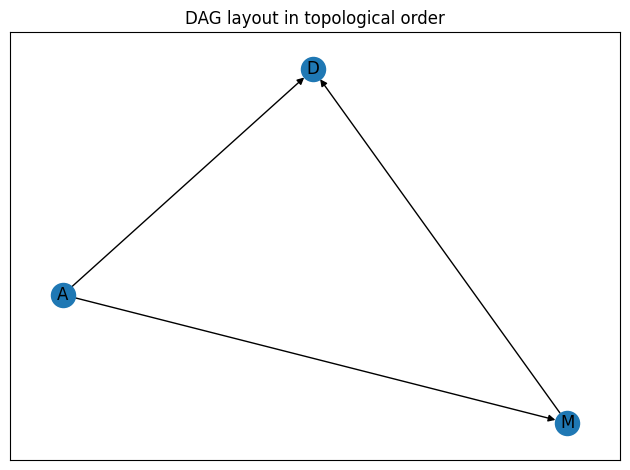

In [70]:
import networkx as nx
import matplotlib.pyplot as plt


G = nx.DiGraph(
    [
        ("A", "M"),
        ("A", "D"),
        ("M", "D"),
    ]
)

for layer, nodes in enumerate(nx.topological_generations(G)):
    # `multipartite_layout` expects the layer as a node attribute, so add the
    # numeric layer value as a node attribute
    for node in nodes:
        G.nodes[node]["layer"] = layer

# Compute the multipartite_layout using the "layer" node attribute
# pos = nx.multipartite_layout(G, subset_key="layer")

fig, ax = plt.subplots()
nx.draw_networkx(G, ax=ax)
ax.set_title("DAG layout in topological order")
fig.tight_layout()
plt.show()

In [71]:
idata_m5_3.posterior

<xarray.Dataset> Size: 436kB
Dimensions:  (chain: 1, draw: 1000, obs_id: 50)
Coordinates:
  * chain    (chain) int32 4B 0
  * draw     (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * obs_id   (obs_id) int32 200B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
Data variables:
    a        (chain, draw) float64 8kB -0.09142 0.06915 ... -0.02544 0.03899
    bA       (chain, draw) float64 8kB -0.715 -0.8533 ... -0.4577 -0.6297
    bM       (chain, draw) float64 8kB -0.1135 -0.2018 ... 0.02855 -0.1563
    sigma    (chain, draw) float64 8kB 0.7692 0.6926 0.7423 ... 0.7818 0.8038
    mu       (chain, draw, obs_id) float64 400kB 0.3395 0.2237 ... 0.5421

In [73]:
az.style.use("arviz-doc")

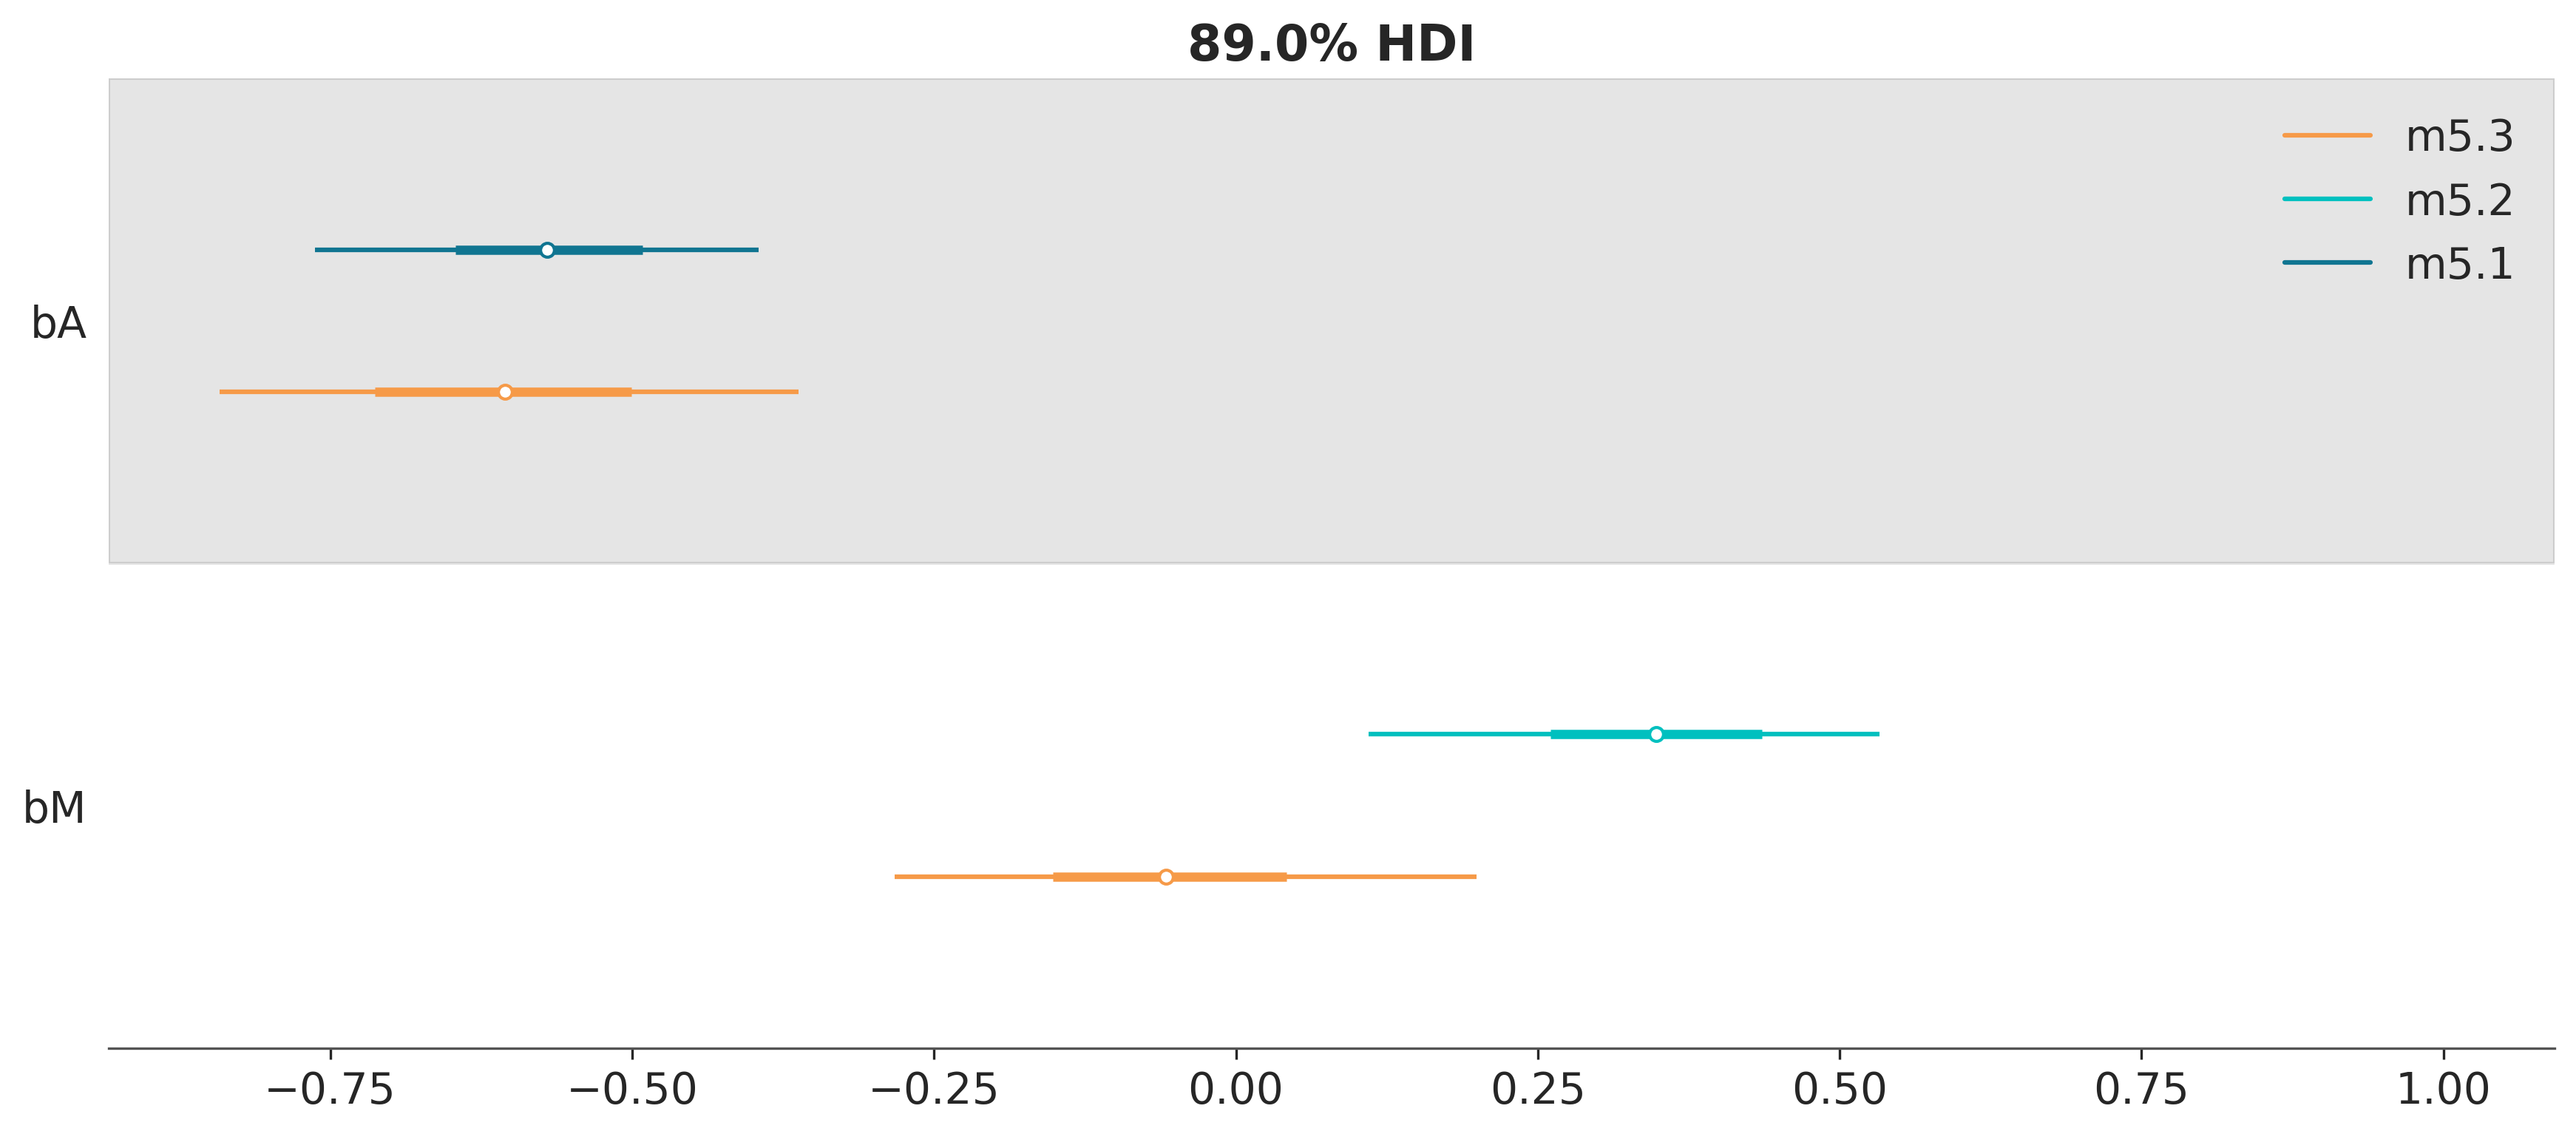

In [75]:
coeftab = {
    "m5.1": idata_m5_1.posterior,
    "m5.2": idata_m5_2.posterior,
    "m5.3": idata_m5_3.posterior,
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bA", "bM"],
    hdi_prob=0.89,
    figsize=(11.5, 5),
)
plt.show()